In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
from rdkit import Chem
from dfs_transformer.utils import Smiles2Mol, Mol2Smiles, DFSCode2Graph, Graph2Mol, isValid, Smiles2DFSCode, DFSCode2Smiles, isValidMoleculeDFSCode
from dfs_transformer.utils import load_selfattn_wandb, load_selfattn_local, computeChemicalValidityAndNovelty, parseChempropAtomFeatures, parseChempropBondFeatures
from dfs_transformer.utils import FeaturizedDFSCodes2Nx, Mol2Nx, Nx2Mol
import os.path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import dfs_transformer as dfs
import numpy as np
from ml_collections import ConfigDict
import yaml
import functools
import tqdm
import traceback

In [2]:
pretrained_model = "r2r045-c4s-noprop"
pretrained_project = "pubchem_newencoding"
force_download = False
if os.path.isdir("../../wandb/artifacts/%s"%pretrained_model) and not force_download:
    bert, cfg = load_selfattn_local("../../wandb/artifacts/%s"%pretrained_model)
else:
    bert, cfg = load_selfattn_wandb(pretrained_model, wandb_dir="../../wandb", pretrained_project=pretrained_project)

In [3]:
bert = bert.eval()

In [4]:
with open("../../config/selfattn/data/pubchem1M.yaml") as file:
    d = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))

In [5]:
d.no_features = cfg.data.no_features

In [6]:
cfg.training.fraction_missing = 0.15

In [7]:
if cfg.training.mode == "rnd2rnd":
    collate_fn = functools.partial(dfs.collate_BERT, 
                                   mode=cfg.training.mode, 
                                   fraction_missing = cfg.training.fraction_missing,
                                   use_loops=cfg.model.use_loops)
elif cfg.training.mode == "rnd2rnd_entry":
    collate_fn = functools.partial(dfs.collate_BERT_entries, 
                                   mode="rnd2rnd", 
                                   fraction_missing = cfg.training.fraction_missing,
                                   use_loops=cfg.model.use_loops)

In [ ]:
trainset = dfs.PubChem(d.path, max_nodes=d.max_nodes, max_edges=d.max_edges, noFeatures=d.no_features,
                   molecular_properties=d.molecular_properties, useDists=d.useDists, useHs=d.useHs,
                   filter_unencoded=False)

  0%|                                                                                                                                                                                        | 0/7 [00:00<?, ?it/s]

In [10]:
smiles_list = [d.smiles for d in trainset]

with open('/mnt/ssd/datasets/pubchem1M.txt', 'w') as f:
    f.write(''.join(smiles_list))

In [9]:
validset = dfs.PubChem(d.valid_path, max_nodes=d.max_nodes, max_edges=d.max_edges, noFeatures=d.no_features,
                   molecular_properties=d.molecular_properties, useDists=d.useDists, useHs=d.useHs,
                   filter_unencoded=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9978/9978 [00:14<00:00, 683.28it/s]


In [10]:
validloader = DataLoader(validset, batch_size=50, shuffle=False, 
                         pin_memory=True, collate_fn=collate_fn, num_workers=4,
                         prefetch_factor=2)

# this part only works if missing_fraction = 0
graphs = []
for data in tqdm.tqdm(validloader):
    graphs += FeaturizedDFSCodes2Nx(data[0])

bad_smiles = []
for dd, graph in tqdm.tqdm(zip(validset, graphs)):
    mol = Nx2Mol(graph)
    try:
        smiles1 = Chem.MolToSmiles(Chem.MolFromSmiles(dd.smiles))
        #print(smiles1)
        mol = Nx2Mol(graph)
        smiles2 = Chem.MolToSmiles(mol)
        #print(smiles2)
        assert smiles1 == smiles2
    except:
        bad_smiles += [smiles1]

bad_smiles

len(bad_smiles)/len(validset)

In [11]:
device = torch.device('cuda:%d'%0 if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
to_cuda = functools.partial(dfs.utils_to_cuda, device=device)

In [12]:
bert = bert.to(device)

In [13]:
def eval_graphs(graphs):
    valid_list = []
    mols = []
    same_list = []
    for graph, data in zip(graphs, validset[:len(graphs)]):
        try:
            valid_list += [isValid(Nx2Mol(graph))]
        except Exception as e:
            #print("yoo", e)
            #traceback.print_exc()
            valid_list += [False]
        try: 
            if valid_list[-1]:
                smiles_orig = Mol2Smiles(Chem.MolFromSmiles(data.smiles))
                smiles_rec = Chem.MolToSmiles(Nx2Mol(graph))
                same_list += [smiles_orig == smiles_rec]
                if not same_list[-1]:
                    mols += [Chem.MolFromSmiles(data.smiles)]
                    mols += [Nx2Mol(graph)]
        except Exception as e:
            print(e)
            print("----------------------")
    valid = np.asarray(valid_list)
    same = np.asarray(same_list)
    print("%2.4f valid molecules"%((valid.sum()/len(valid))))
    print("%2.4f of the valid molecules stayed the same"%(same.sum()/len(same)))
    return valid, same, mols

In [14]:
graphs = []
for data in tqdm.tqdm(validloader):
    data = [to_cuda(d) for d in data]
    graphs += bert.fwd_graph(data[0], data[1])
valid, same, mols = eval_graphs(graphs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:34<00:00,  5.82it/s]


0.9704 valid molecules
0.9450 of the valid molecules stayed the same


0.8520 valid molecules
0.8038 of the valid molecules stayed the same
0.8521 valid molecules
0.8037 of the valid molecules stayed the same

In [15]:
graphs1 = []
graphs2 = []
for idx, data in tqdm.tqdm(enumerate(validloader)):
    data = [to_cuda(d) for d in data]
    graphs1 += bert.fwd_smart(data[0], data[1])
    graphs2 += bert.fwd_graph(data[0], data[1])

valid, same, mols = eval_graphs(graphs1)
valid, same, mols = eval_graphs(graphs2)

199it [05:02,  1.52s/it]


0.9700 valid molecules
0.9468 of the valid molecules stayed the same
0.9700 valid molecules
0.9467 of the valid molecules stayed the same


In [16]:
graphs = []
for data in tqdm.tqdm(validloader):
    data = [to_cuda(d) for d in data]
    graphs += bert.fwd_graph(data[0], data[1])
valid, same, mols = eval_graphs(graphs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:33<00:00,  5.90it/s]


0.9694 valid molecules
0.9451 of the valid molecules stayed the same


/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


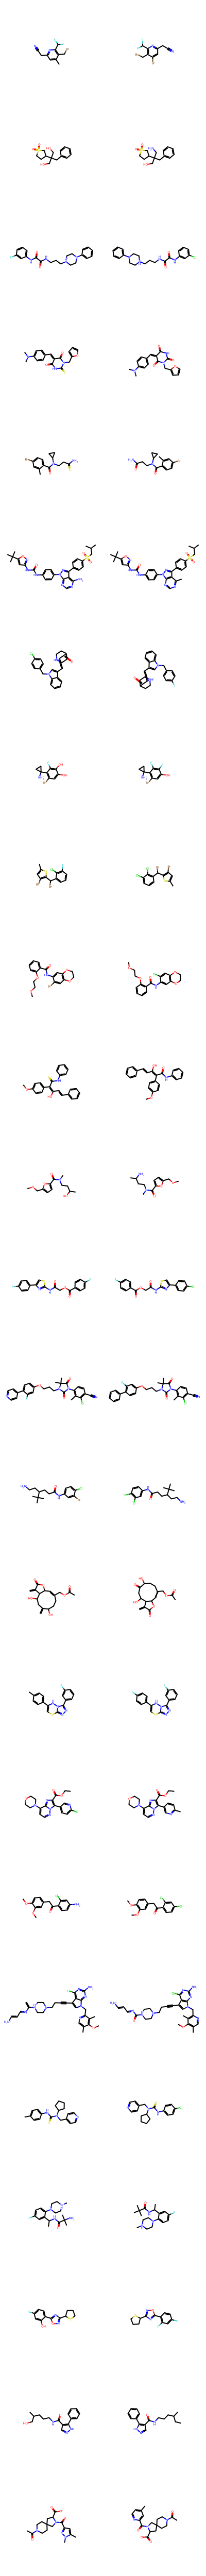

In [17]:
Chem.Draw.MolsToGridImage(mols, molsPerRow=2)

In [18]:
graphs = []
for data in tqdm.tqdm(validloader):
    data = [to_cuda(d) for d in data]
    graphs += bert.fwd_graph_sample(data[0], data[1])
valid, same, mols = eval_graphs(graphs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:40<00:00,  4.86it/s]


0.9245 valid molecules
0.9428 of the valid molecules stayed the same


In [19]:
graphs = []
for data in tqdm.tqdm(validloader):
    data = [to_cuda(d) for d in data]
    graphs += bert.fwd_graph_all(data[0])
valid, same, mols = eval_graphs(graphs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:32<00:00,  6.13it/s]


0.9645 valid molecules
0.9419 of the valid molecules stayed the same


In [20]:
graphs = []
for data in tqdm.tqdm(validloader):
    data = [to_cuda(d) for d in data]
    graphs += bert.fwd_graph_all_sample(data[0])
valid, same, mols = eval_graphs(graphs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:39<00:00,  5.02it/s]


0.9046 valid molecules
0.9440 of the valid molecules stayed the same


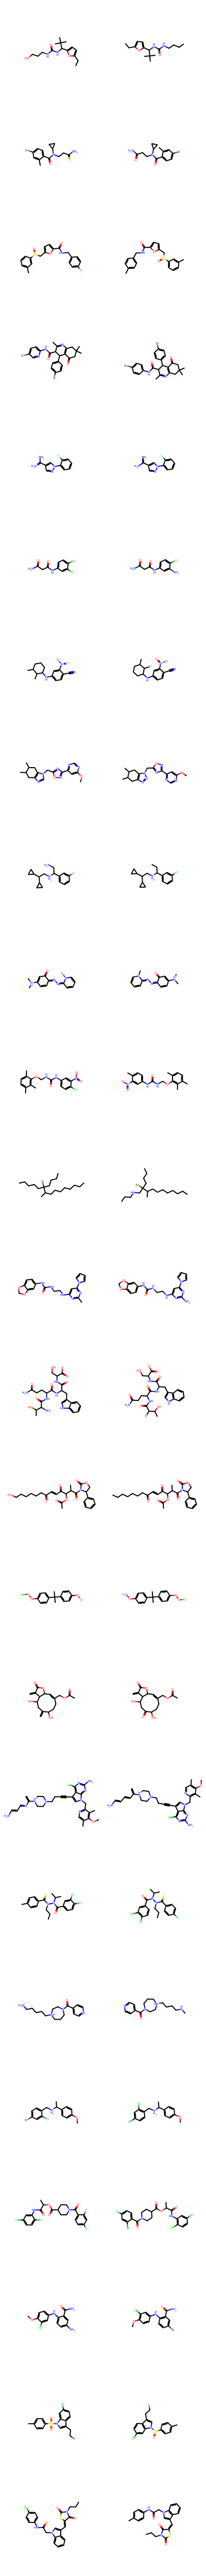

In [21]:
Chem.Draw.MolsToGridImage(mols, molsPerRow=2)